In [227]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from sklearn.linear_model import Lasso

import pysindy as ps
import pandas as pd
import numpy as np

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

plt.style.use('ggplot')

In [228]:
from stesml.data_tools import get_scenario_index
from stesml.data_tools import get_train_and_val_index
from stesml.data_tools import load_data

from stesml.postprocessing_tools import get_m
from stesml.postprocessing_tools import get_Cp
from stesml.postprocessing_tools import get_As
from stesml.postprocessing_tools import get_Ac

from stesml.model_tools import final_train
from stesml.model_tools import validate_model

from stesml.stes_model import stes_model

In [229]:
data_dir = "../data/Sulfur_Models/heating/heating_all"

In [230]:
t_min = 359
t_max = -1

# If using PySINDy to get general equations starting at a point other than t = 0,
# then we need another model to provide a prediction for the starting point.
if t_min > 0: 
    hybrid = True
else:
    hybrid = False

In [231]:
scenario_index = get_scenario_index(data_dir)

In [232]:
train_index, val_index = get_train_and_val_index(scenario_index, random_state=5)

In [233]:
train_data_ = load_data(scenario_index, train_index, t_min=t_min, t_max=t_max)
train_df = train_data_[['Tw','Ti','Tavg']]
train_df.index = train_data_['flow-time']

In [234]:
val_data_ = load_data(scenario_index, val_index, t_min=t_min, t_max=t_max)
val_df = val_data_[['Tw','Ti','Tavg']]
val_df.index = val_data_['flow-time']

In [235]:
train_data = list()
train_index = list()
for idx, grp in train_df.groupby(["Tw", "Ti"]):
    train_data.append(grp.values)
    train_index.append(grp.index.values)

In [236]:
val_data = list()
val_index = list()
for idx, grp in val_df.groupby(["Tw", "Ti"]):
    val_data.append(grp.values)
    val_index.append(grp.index.values)

In [237]:
poly_library = ps.feature_library.PolynomialLibrary(degree=3)
optimizer = ps.STLSQ(threshold=0,normalize_columns=True,verbose=True)
model = ps.SINDy(optimizer=optimizer, feature_names=['Tw','Ti','Ts'], feature_library=poly_library)

In [238]:
model.fit(train_data, t=train_index, multiple_trajectories=True)

 Iteration ... |y - Xw|^2 ...  a * |w|_2 ...      |w|_0 ... Total error: |y - Xw|^2 + a * |w|_2
         0 ... 1.7918e+01 ... 8.8889e+00 ...         60 ... 2.6807e+01


SINDy(differentiation_method=FiniteDifference(),
      feature_library=PolynomialLibrary(degree=3),
      feature_names=['Tw', 'Ti', 'Ts'],
      optimizer=STLSQ(normalize_columns=True, threshold=0, verbose=True))

In [239]:
model.print(precision=7)

(Tw)' = 0.0000000
(Ti)' = 0.0000000
(Ts)' = 0.3356342 1 + 0.0014296 Tw + 0.0013240 Ti + -0.0046626 Ts + -0.0000048 Tw^2 + -0.0000027 Tw Ti + 0.0000069 Tw Ts + 0.0000016 Ti^2 + -0.0000050 Ti Ts + 0.0000076 Ts^2


In [240]:
n_cases = len(val_data)

In [241]:
if hybrid:
    # Load NN model to get initial point for T at t=360s
    model_name = 'NN_20220708-22'
    model_type = 'NN' # Options: NN, XGBoost, RandomForest
    target = 'Tavg' # Options: Tavg, h
    metric = 'rmse' # Options: rmse, r2
    scale = True # Normalize data to a mean of 0 and STD of 1
    t_max = t_min
    T_model, addendum = stes_model.load_model(model_type, model_name)
    T_results = validate_model(T_model, model_type, data_dir, target, scale, addendum, t_min=1, t_max=t_max)
    T_df_ = T_results['val_df']
    T_df_.index = T_df_['flow-time']
    T_df = T_df_[['Tw','Ti','Tavg']]
    T_df.index = T_df_['flow-time']
    T_data = list()
    T_index = list()
    for idx, grp in T_df.groupby(["Tw", "Ti"]):
        T_data.append(grp.values)
        T_index.append(grp.index.values)

RMSE: 0.2993692, R2: 0.9999731


In [242]:
if hybrid:
    # These are the NN model predictions for T at t=360
    for i in range(n_cases):
        print(T_data[i][-1])

[440.         420.         421.48360989]
[460.         440.         441.81074262]
[480.         400.         405.31942221]
[500.         440.         445.55223805]
[520.         440.         446.62928604]
[540.         460.         467.15166281]
[540.        520.        522.0594575]
[560.         440.         448.57787851]
[580.         420.         430.93211347]
[580.         500.         506.57054293]
[580.         560.         561.66823246]
[600.         460.         470.62958822]
[600.         500.         507.77344218]
[600.         520.         526.02924603]
[620.         420.         433.72359808]
[640.         460.         473.17605929]
[660.         560.         567.65519473]
[660.         620.         623.15531635]


In [243]:
predictions = list()
Tdot_predictions = list()
for i in range(n_cases):
    if hybrid:
        prediction = model.simulate(x0=np.array(T_data[i][-1]).reshape(3),t=val_index[i]) # For Hybrid: Provide the prediction from the NN model
    else:
        prediction = model.simulate(x0=np.array(val_data[i][0]).reshape(3),t=val_index[i]) # Ti is initial point for simulation
    Tdot_prediction = model.predict(prediction)
    predictions.append(prediction)
    Tdot_predictions.append(Tdot_prediction)

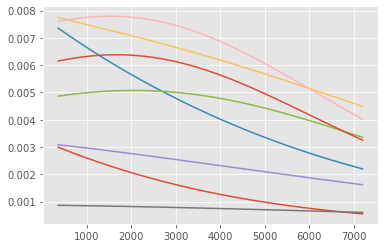

In [245]:
for i in range(n_cases):
    if val_index[i][-1] < 1000:
        continue
    plt.plot(val_index[i], Tdot_predictions[i][:,2])

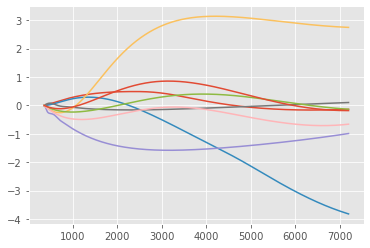

In [246]:
for i in range(n_cases):
    if val_index[i][-1] < 1000:
        continue
    plt.plot(val_index[i], val_data[i][:,2] - predictions[i][:,2])

In [247]:
predictions_joined = list()
val_data_joined = list()

for i in range(n_cases):
    val_data_joined += val_data[i][:,2].tolist()
    predictions_joined += predictions[i][:,2].tolist()

In [248]:
r2 = r2_score(val_data_joined, predictions_joined)
rmse = mean_squared_error(val_data_joined, predictions_joined, squared=False)
print(f'RMSE: {rmse}, R2: {r2}')

RMSE: 1.2419203650261623, R2: 0.9993147352817029


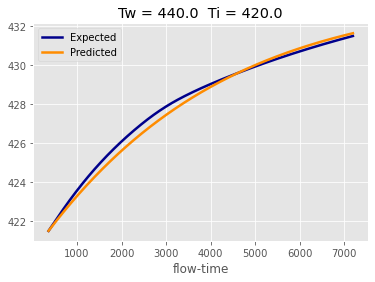

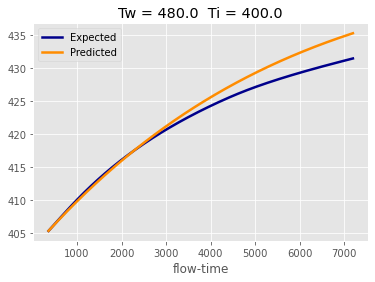

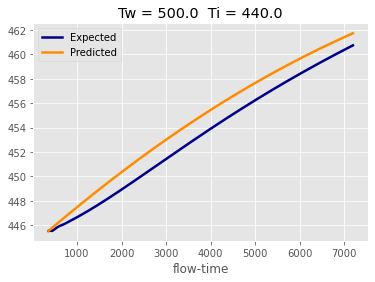

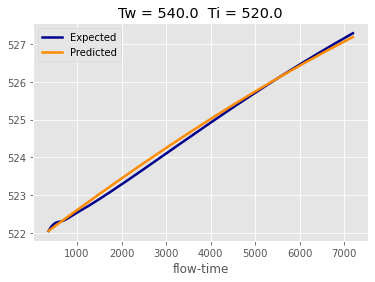

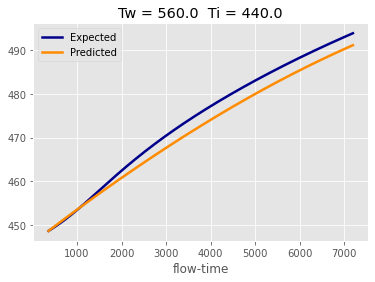

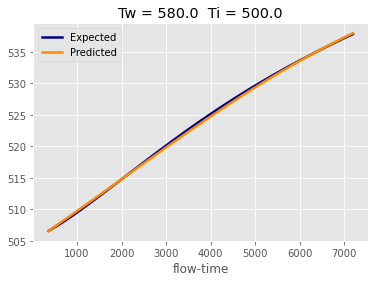

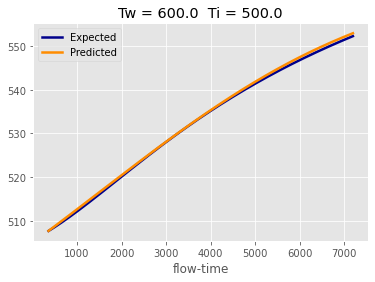

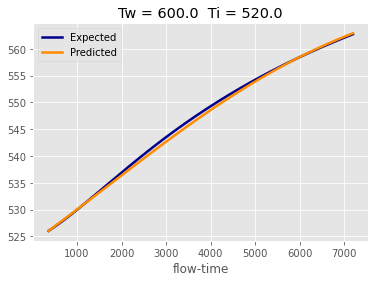

In [249]:
plt.style.use('ggplot')
for i in range(len(val_data)):
    if val_index[i][-1] < 1000:
        continue
    Tw = val_data[i][:,0][0]
    Ti = val_data[i][:,1][0]
    plt.plot(val_index[i], val_data[i][:,2], linewidth=2.5, c='DarkBlue', label='Expected')
    plt.plot(val_index[i], predictions[i][:,2], linewidth=2.5, c='DarkOrange', label='Predicted')
    plt.xlabel('flow-time')
    plt.title(f'Tw = {Tw}  Ti = {Ti}')
    plt.legend()
    plt.show()

In [250]:
# Getting properties to calculate h
Tw = list()
Ti = list()
T = list()
Tdot = list()

for i in range(n_cases):
    Tw += val_data[i][:,0].tolist()
    Ti += val_data[i][:,1].tolist()
    T += predictions[i][:,2].tolist()
    Tdot += Tdot_predictions[i][:,2].tolist()

Ac = get_Ac()
m = get_m(T, Ac)
Cp = get_Cp(T)

T = np.array(T)
Tw = np.array(Tw)
Ti = np.array(Ti)
m = np.array(m)
Cp = np.array(Cp)
As = get_As()

In [251]:
h_hat = m*Cp*Tdot/(As*(Tw-T))

In [252]:
flow_time = list()
for i in range(n_cases):
    flow_time += val_index[i].tolist()

In [253]:
h_hat_df = pd.DataFrame()
h_hat_df['Tw'] = Tw
h_hat_df['Ti'] = Ti
h_hat_df['h_hat'] = h_hat
h_hat_df['T_hat'] = T
h_hat_df['flow-time'] = flow_time
h_hat_df.index = h_hat_df['flow-time']

In [254]:
h_df = val_data_[['Tw','Ti','h','flow-time']]
h_df.index = val_data_['flow-time']

In [255]:
# Need to sort dataframes because the cases are not in the same order
h_df_sorted = h_df.sort_values(by=['Tw','Ti'])
h_hat_df_sorted = h_hat_df.sort_values(by=['Tw','Ti'])

In [256]:
h_hat_df_sorted['h'] = h_df_sorted['h']

In [257]:
r2 = r2_score(h_hat_df_sorted['h'],h_hat_df_sorted['h_hat'])
rmse = mean_squared_error(h_hat_df_sorted['h'],h_hat_df_sorted['h_hat'], squared=False)
print(f'RMSE: {rmse}, R2: {r2}')

RMSE: 5.3685121679534396, R2: 0.7862349198262684


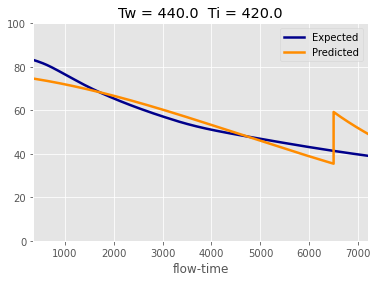

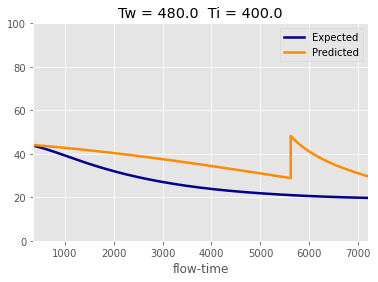

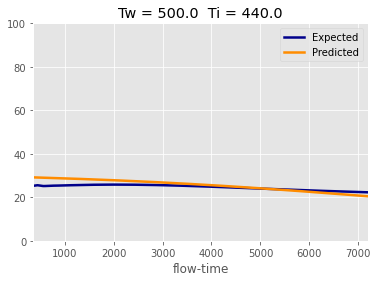

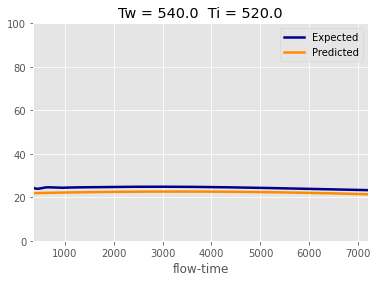

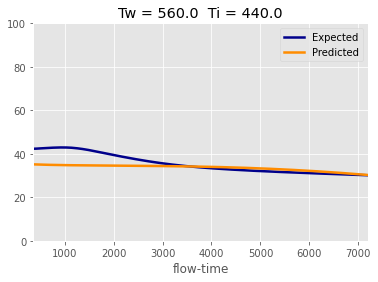

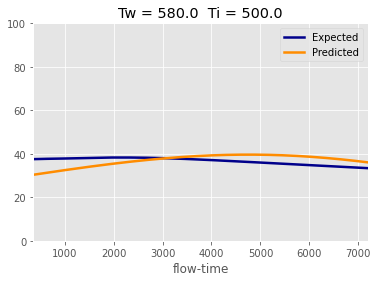

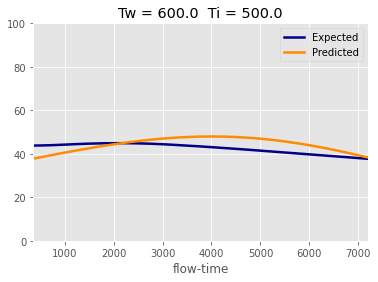

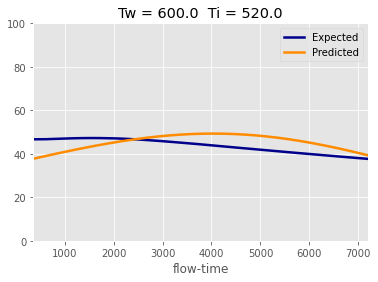

In [259]:
for idx, grp in h_hat_df_sorted.groupby(['Tw','Ti']):
    if grp['flow-time'].iloc[-1] < 1000:
        continue
    plt.plot(grp['flow-time'], grp['h'], linewidth=2.5, c='DarkBlue', label='Expected')
    plt.plot(grp['flow-time'], grp['h_hat'], linewidth=2.5, c='DarkOrange', label='Predicted')
    plt.xlabel('flow-time')
    plt.xlim(t_min,7200)
    plt.ylim(0,100)
    Tw = grp['Tw'].iloc[0]
    Ti = grp['Ti'].iloc[0]
    plt.title(f'Tw = {Tw}  Ti = {Ti}')
    plt.legend()
    plt.show()